In [1]:
import os
import sys

import nltk
import tweepy
from dotenv import load_dotenv
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from datetime import datetime
import re
import cv2
import numpy as np
import pandas as pd
import pickle
# NOTE: THE WORDCLOUD PACKAGE ISN'T WORKING FOR SOME VERSIONS OF PYTHON.
# LOCKING PYTHON VERSION TO 3.7 BECAUSE OF THAT.
from wordcloud import WordCloud
import spacy
import spacy_transformers
import torch

In [2]:
import ssl
def set_up_ssl():
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

set_up_ssl()

In [3]:
load_dotenv()
TWITTER_BEARER_TOKEN = os.getenv('TWITTER_BEARER_TOKEN')
TWITTER_API_KEY = os.getenv('TWITTER_API_KEY')
TWITTER_API_SECRET_KEY = os.getenv('TWITTER_API_SECRET_KEY')
TWITTER_ACCESS_TOKEN = os.getenv('TWITTER_ACCESS_TOKEN')
TWITTER_ACCESS_TOKEN_SECRET = os.getenv('TWITTER_ACCESS_TOKEN_SECRET')

In [4]:
print("Authenticating to Twitter...")

client = tweepy.Client(bearer_token=TWITTER_BEARER_TOKEN, wait_on_rate_limit=True)
auth = tweepy.OAuthHandler(TWITTER_API_KEY, TWITTER_API_SECRET_KEY)
auth.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

Authenticating to Twitter...


In [5]:
twitter_russia_sources_rus_usernames = ["@1tvru_news", "@ru_rbc",
                                         "@er_novosti",
                              "@rt_com",
                              "@medvedevrussia", "@kremlinrussia",
                              "@rentvchannel", "@vesti_news", "@kpru"]

twitter_ukraine_sources_rus_usernames = ["@dmitry_gordon", "@SvobodaRadio",
                               "@euronewsru", "@FeyginMark4", "@tvrain", "@teamnavalny"]

twitter_ukraine_sources_ukr_usernames = ["@HromadskeUA", "@tsnua", "@24tvua", "@unian",
                               "@radiosvoboda", "@5channel", "@EspresoTV"]

twitter_ukraine_sources_eng_usernames = ["@mschwirtz", "@KyivIndependent", "@KyivPost",
                               "@mchancecnn", "@fpleitgenCNN", "@Kasparov63",
                               "@ikhurshudyan", "@myroslavapetsa",
                               "@langfittnpr", "@ElBeardsley", "@timkmak"]

https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9

In [6]:
def get_user_id_from_username(username):
    user = api.get_user(screen_name=username)
    return user.id

In [7]:
russia_sources_rus = []
ukraine_sources_rus = []
ukraine_sources_ukr = []
ukraine_sources_eng = []

In [8]:
LOAD_CLUSTERS_DATA = True

In [9]:
if not LOAD_CLUSTERS_DATA:
    for username in twitter_russia_sources_rus_usernames:
        russia_sources_rus.append((username, get_user_id_from_username(username)))

    for username in twitter_ukraine_sources_rus_usernames:
        ukraine_sources_rus.append((username, get_user_id_from_username(username)))

    for username in twitter_ukraine_sources_ukr_usernames:
        ukraine_sources_ukr.append((username, get_user_id_from_username(username)))

    for username in twitter_ukraine_sources_eng_usernames:
        ukraine_sources_eng.append((username, get_user_id_from_username(username)))

In [10]:
if not LOAD_CLUSTERS_DATA:
    russia_sources_rus_pickled = pickle.dumps(russia_sources_rus)
    ukraine_sources_rus_pickled = pickle.dumps(ukraine_sources_rus)
    ukraine_sources_ukr_pickled = pickle.dumps(ukraine_sources_ukr)
    ukraine_sources_eng_pickled = pickle.dumps(ukraine_sources_eng)

In [11]:
CLUSTERS_SERIALIZATION_DIR = "data_clusters/"

In [12]:
if not LOAD_CLUSTERS_DATA:
    print("Writing pickled data to a file...")

    with open(CLUSTERS_SERIALIZATION_DIR + 'russia_sources_rus_pickled.pickle', 'wb') as f:
        f.write(russia_sources_rus_pickled)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_rus_pickled.pickle', 'wb') as f:
        f.write(ukraine_sources_rus_pickled)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_ukr_pickled.pickle', 'wb') as f:
        f.write(ukraine_sources_ukr_pickled)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_eng_pickled.pickle','wb') as f:
        f.write(ukraine_sources_eng_pickled)

In [13]:
if LOAD_CLUSTERS_DATA:
    with open(CLUSTERS_SERIALIZATION_DIR + 'russia_sources_rus_pickled.pickle',\
            'rb') as f:
        russia_sources_rus = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_rus_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_rus = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_ukr_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_ukr = pickle.load(f)

    with open(CLUSTERS_SERIALIZATION_DIR + 'ukraine_sources_eng_pickled' \
            '.pickle', 'rb') as f:
        ukraine_sources_eng = pickle.load(f)

In [14]:
def get_user_followers(user_name, user_id, num_pages=1, num_followers=10):
    followers = []
    # User rate limit (User context): 15 requests per 15-minute window per each authenticated user
    # limit – Maximum number of requests to make to the API
    # max_results : The maximum number of results to be returned per page. This can be a number between 1 and the 1000. By default, each page will return 100 results.
    # I.E. 15 000 followers can be returned in 15 minutes
    followers_paginator = tweepy.Paginator(client.get_users_followers, id =
    user_id, max_results = num_followers, limit = num_pages).flatten()
    for follower in followers_paginator:
        followers.append(follower)
    return (user_name, user_id), followers

In [15]:
def get_user_follower_count(user_id):
    # fetching the user
    user = api.get_user(user_id = user_id)
    return user.followers_count

In [16]:
rus_cluster_followers = []
ukr_eng_cluster_followers = []
ukr_rus_cluster_followers = []
ukr_ukr_cluster_followers = []

In [17]:
# PROBLEM: pickling followers causes recursion depth exceeded problem
# SOLUTION: process the followers data right away and write the result in csv
# format

LOAD_FOLLOWERS = False
FOLLOWERS_DIR = "followers/"

In [18]:
# PRODUCTION CODE
# get 105 000 followers per cluster: 1:45 min per cluster, 105 requests

'''
if  not LOAD_FOLLOWERS:
    for cluster in russia_sources_rus:
        rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))

    for cluster in ukraine_sources_rus:
        ukr_eng_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))

    for cluster in ukraine_sources_ukr:
        ukr_rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))

    for cluster in ukraine_sources_eng:
        ukr_ukr_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))
'''

'\nif  not LOAD_FOLLOWERS:\n    for cluster in russia_sources_rus:\n        rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n\n    for cluster in ukraine_sources_rus:\n        ukr_eng_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n\n    for cluster in ukraine_sources_ukr:\n        ukr_rus_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n\n    for cluster in ukraine_sources_eng:\n        ukr_ukr_cluster_followers.append(get_user_followers(cluster[0], cluster[1]))\n'

In [19]:
# TEST CODE: 50 followers per cluster, 2 cluster per each
if not LOAD_FOLLOWERS:
    for i in range(0, 2):
        rus_cluster_followers.append(get_user_followers(russia_sources_rus[i][0],                                               russia_sources_rus[i][1]))

    for i in range(0, 2):
        ukr_eng_cluster_followers.append(get_user_followers(ukraine_sources_rus[i][0],                                               ukraine_sources_rus[i][1]))

In [20]:
type(rus_cluster_followers)

list

In [21]:
if not LOAD_FOLLOWERS:
    rus_cluster_followers_pickled = pickle.dumps(rus_cluster_followers)
    ukr_eng_cluster_followers_pickled = pickle.dumps(ukr_eng_cluster_followers)
    ukr_rus_cluster_pickled = pickle.dumps(ukr_rus_cluster_followers)
    ukr_ukr_cluster_pickled = pickle.dumps(ukr_ukr_cluster_followers)

In [22]:
if not LOAD_FOLLOWERS:
    print("Writing pickled data to a file...")

    with open(FOLLOWERS_DIR + 'rus_cluster_followers.pickle', 'wb') as f:
        f.write(rus_cluster_followers_pickled)

    with open(FOLLOWERS_DIR + 'ukr_eng_cluster_followers.pickle', 'wb') as f:
        f.write(ukr_eng_cluster_followers_pickled)

    with open(FOLLOWERS_DIR + 'ukr_rus_cluster_followers.pickle', 'wb') as f:
        f.write(ukr_rus_cluster_pickled)

    with open(FOLLOWERS_DIR + 'ukr_ukr_cluster_followers.pickle','wb') as f:
        f.write(ukr_ukr_cluster_pickled)

In [24]:
# NOTE: causes recursion depth exceeded problem

if LOAD_FOLLOWERS:

    with open(FOLLOWERS_DIR + 'rus_cluster_followers.pickle',\
            'rb') as f:
        rus_cluster_followers = pickle.load(f)

    with open(FOLLOWERS_DIR + 'ukr_eng_cluster_followers' \
            '.pickle', 'rb') as f:
        ukr_eng_cluster_followers = pickle.load(f)

    with open(FOLLOWERS_DIR + 'ukr_rus_cluster_followers' \
            '.pickle', 'rb') as f:
        ukr_rus_cluster_followers = pickle.load(f)

    with open(FOLLOWERS_DIR + 'ukr_ukr_cluster_followers' \
            '.pickle', 'rb') as f:
        ukr_ukr_cluster_followers = pickle.load(f)

RecursionError: maximum recursion depth exceeded

In [24]:
print(ukr_eng_cluster_followers)

[]


In [25]:
'''
print(type(followers[('@minregion_ua', 3333475643)][0]))
print(followers[('@minregion_ua', 3333475643)][0].name)
print(followers[('@minregion_ua', 3333475643)][0].id)
'''

"\nprint(type(followers[('@minregion_ua', 3333475643)][0]))\nprint(followers[('@minregion_ua', 3333475643)][0].name)\nprint(followers[('@minregion_ua', 3333475643)][0].id)\n"

In [26]:
CLUSTER_IDX = 0
FOLLOWER_IDX = 1

rus_cluster = {}
ukr_eng_cluster = {}
ukr_rus_cluster = {}
ukr_ukr_cluster = {}

In [27]:
def cluster_to_df(cluster_list):

    cluster_dfs = {}

    for cluster in cluster_list:
        follower_names = [follower.name for follower in cluster[FOLLOWER_IDX]]
        follower_ids = [follower.id for follower in cluster[FOLLOWER_IDX]]
        followers_data = {
            'username': follower_names,
            'user_id': follower_ids
        }
        cluster_dfs[cluster[CLUSTER_IDX]] = pd.DataFrame(followers_data)

    return cluster_dfs

In [28]:
rus_cluster = cluster_to_df(rus_cluster_followers)
ukr_eng_cluster = cluster_to_df(ukr_eng_cluster_followers)
ukr_rus_cluster = cluster_to_df(ukr_rus_cluster_followers)
ukr_ukr_cluster = cluster_to_df(ukr_ukr_cluster_followers)

In [29]:
# this fucntion converts a list of cluster centers and their followers to csv
# files
CLUSTERS_DIR = "clusters/"

def clusters_to_files(clusters_df):
    for cluster_center, cluster_followers in clusters_df.items():
        cluster_csv = cluster_followers.to_csv()
        with open(CLUSTERS_DIR + cluster_center[CLUSTER_IDX][1:] + '_' + str(cluster_center[FOLLOWER_IDX]) + '.csv',
                  'w') as f:
            f.write(cluster_csv)

In [30]:
clusters_to_files(rus_cluster)
clusters_to_files(ukr_eng_cluster)

<h2>Visualizing Connections as a Graph</h2>

In [79]:
ukr_eng_cluster[('@dmitry_gordon',
  1334400780)]

,username,user_id
0,Kryp4ek,1476613048018382850
1,Батал Гамгия,1599163293746302976
2,Елена Письменюк,1599155737766281218
3,stieroglif,492418187
4,Алекс,1599150982625218560
...,...,...
994,osokinnnnnnn,1531585954607161347
995,tterewew,926760353878253568
996,Artur Kazarian,1595900167667990530
997,Виталий Жижанов,1576624669863591938


In [80]:
import networkx as nx

In [89]:
print("Creating a DataFrame containing the complete graph")

GROUP_ID_MAP = {
    "rus_cluster": 0,
    "ukr_eng_cluster": 1,
    "ukr_rus_cluster": 2,
    "ukr_ukr_cluster": 3
}

global_graph_pd = pd.DataFrame(columns=['username', 'user_id',
                                     'cluster_name', 'cluster_id',
                                     'cluster_follow_count', 'group_id'])

Creating a DataFrame containing the complete graph


In [95]:
def add_cluster_to_global_graph(cluster, group_name, graph_pd):
    curr_cluster_df = pd.DataFrame()
    for cluster_center, cluster_followers in cluster.items():
        curr_cluster_df = cluster_followers.copy(deep=True)
        curr_cluster_df.insert(2, "cluster_name", cluster_center[0])
        curr_cluster_df.insert(3, "cluster_id", int(cluster_center[1]))
        curr_cluster_df.insert(4, "cluster_follow_count",
                               get_user_follower_count(cluster_center[1]),
                               True)
        curr_cluster_df.insert(5, "group_id", GROUP_ID_MAP[group_name])
    return pd.concat([graph_pd, curr_cluster_df])

In [91]:
def save_image(img, img_name):
    IMG_DIR = "visualizations/"
    plt.imsave(IMG_DIR + img_name, img)

In [92]:
global_graph_pd = add_cluster_to_global_graph(rus_cluster, "rus_cluster", global_graph_pd)
global_graph_pd = add_cluster_to_global_graph(ukr_eng_cluster, "ukr_eng_cluster",
                                              global_graph_pd)

TwitterServerError: 503 Service Unavailable
130 - Over capacity

In [ ]:
print(global_graph_pd.size)
print(set(global_graph_pd['cluster_name']))

In [93]:
global_graph_pd_columns = list(global_graph_pd.columns)

In [94]:
print("Constructing NetworkX graph")

# what if you store all attributes as edge attributes?
G = nx.from_pandas_edgelist(global_graph_pd, source='username',
                            target='cluster_name', edge_attr = global_graph_pd_columns,
                             create_using=nx.DiGraph())

pos = nx.spring_layout(G)

Constructing NetworkX graph


In [86]:
print("Visualizing a small subset of connections...")

subgraph = G.subgraph(list(G.nodes)[:10])

subgraph_pos = nx.spring_layout(subgraph)

nx.draw_networkx(subgraph, subgraph_pos)

Visualizing a small subset of connections...


NameError: name 'G' is not defined

<h2>Network Anslysis Questions:</h2>

1. How many connections are overlapping within each given group. (e.g. how
many people following SWJ also follow NYT)
2. How many overlaps are there in between clusters from different groups?

3. Do nodes cluster into tightly connected groups?

<h2>Network Visualization Questions</h2>

3. Visualize the connections in pretty way
4. Visualize Cluster sizes
5. Visualize groups by color coding them

<h2>Sentiment Analysis Questions</h2>
1. Word Cloud: what are people within each group discussing (Use entity recognition)?

2. Tag Cloud: who are people within each group discussing?

3. What sentiment do mentions within each groups have?

4. What is a general Twitter sentiment on this topic (Can use Ukraine dataset)

<h2>Visualization Techniques that can be leveraged</h2>
1. Network Visualization

2. Coloring nodes

3. Coloring Connections

4. Size of the nodes

5. Shape of the nodes


In [87]:
def get_edge_attributes(graph, attr_list):
    KEY = 0
    VALUE = 1
    edge_attrs = {}
    for attr in attr_list:
        edges_attribute = nx.get_edge_attributes(graph, attr)
        for edge_attr in edges_attribute.items():
            if edge_attr[KEY] in edge_attrs.keys():
                edge_attr_values = edge_attrs[edge_attr[KEY]]
                edge_attr_values.append(edge_attr[VALUE])
                edge_attrs[edge_attr[KEY]] = edge_attr_values
            else:
                edge_attrs[edge_attr[KEY]] = [edge_attr[VALUE]]
    return edge_attrs

edge_attrs = get_edge_attributes(subgraph, global_graph_pd_columns)

print(edge_attrs)

NameError: name 'subgraph' is not defined

In [88]:
print("Running analysis on the network...")

# https://subscription.packtpub.com/book/big-data-and-business-intelligence/9781789955316/7

Running analysis on the network...


In [41]:
import networkx.algorithms.community as nxcom

# identifying communities within the network
twitter_communities = sorted(nxcom.greedy_modularity_communities(G), key=len,
                             reverse=True)

NameError: name 'G' is not defined

In [42]:
print("The number of communities detected is ", len(twitter_communities))

NameError: name 'twitter_communities' is not defined

In [43]:
print("Visualizing Identified Communities")

def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

Visualizing Identified Communities


In [44]:
def get_color(i, r_off=1, g_off=1, b_off=1):
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

In [45]:
# Set node and edge communities
set_node_community(G, twitter_communities)
set_edge_community(G)

# Set community color for nodes
node_color = [
    get_color(G.nodes[v]['community'])
    for v in G.nodes]

# Set community color for internal edges
external = [
    (v, w) for v, w in G.edges
    if G.edges[v, w]['community'] == 0]

internal = [
    (v, w) for v, w in G.edges
    if G.edges[v, w]['community'] > 0]

internal_color = [
    get_color(G.edges[e]['community'])
    for e in internal]

NameError: name 'G' is not defined

In [46]:
# Draw external edges
nx.draw_networkx(
    G, pos=pos, node_size=0,
    edgelist=external, edge_color="#333333",
    alpha=0.2, with_labels=False)

# Draw internal edges
nx.draw_networkx(
    G, pos=pos, node_size=0,
    edgelist=internal, edge_color=internal_color,
    alpha=0.05, with_labels=False)

NameError: name 'G' is not defined

In [47]:
all_clusters = []

all_clusters.extend(rus_cluster)
all_clusters.extend(ukr_eng_cluster)
all_clusters.extend(ukr_rus_cluster)
all_clusters.extend(ukr_ukr_cluster)

all_clusters_dict = {}

for cluster in all_clusters:
    if str(cluster[0]) in G.nodes:
        all_clusters_dict[str(cluster[0])] = str(cluster[0])

NameError: name 'G' is not defined

In [48]:
# TODO: SAVE AS PDF

pos = nx.spring_layout(G, k=0.15)

G_node_degrees = dict(G.degree)

# Draw internal edges
nx.draw_networkx(
    G, pos=pos, node_size=[v * 1 for v in G_node_degrees.values()],
    edgelist=internal, edge_color=internal_color,
    alpha=0.05, with_labels=True, label='Group Follower Clusters',
    labels=all_clusters_dict, font_color='#00ff00', font_weight='bold')

NameError: name 'G' is not defined

In [49]:
def sort_graph_by_deg_desc(graph):
    return sorted(G.degree, key=lambda x: x[1], reverse=True)

In [50]:
G_deg_sorted = sort_graph_by_deg_desc(G)

NameError: name 'G' is not defined

In [51]:
print("Performing connectivity analysis on a graph")

node_connections = nx.all_pairs_node_connectivity(subgraph)

Performing connectivity analysis on a graph


NameError: name 'subgraph' is not defined

In [52]:
def get_shared_nodes_within_group(node_connections, group_members):
    shared_connections = []
    for username, connections_dict in node_connections.items():
        for group_member in group_members:
            if group_member in connections_dict.keys() and connections_dict[group_member] == 1:
                shared_connections.append(username)
    return shared_connections

In [53]:
get_shared_nodes_within_group(node_connections, rus_cluster)

NameError: name 'node_connections' is not defined

In [51]:
def get_shared_nodes_between_groups(node_connections, cluster_groups):
    shared_connections = {}
    for username, connections_dict in node_connections.items():
        for group_name, group_members in cluster_groups.items():
            for group_member in group_members:
                if group_member in connections_dict.keys() and connections_dict[group_member] == 1:
                    if group_name not in shared_connections.keys():
                        shared_connections.append(username)
                    else:
                        shared_connections[group_name] = shared_connections[group_name].append(username)
    return shared_connections

In [52]:
TWITTER_CLUSTER_GROUPS = {
    "rus_cluster": russia_sources_rus,
    "ukr_eng_cluster": ukraine_sources_rus,
    "ukr_rus_cluster": ukraine_sources_ukr,
    "ukr_ukr_cluster": ukraine_sources_eng
}

In [53]:
shared_connections_between_groups = get_shared_nodes_between_groups\
(node_connections, TWITTER_CLUSTER_GROUPS)

In [54]:
shared_connections_between_groups

{}

In [55]:
'''
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(G, pos,
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)
'''

"\nimport matplotlib.pyplot as plt\n\nf, ax = plt.subplots(figsize=(10, 10))\nplt.style.use('ggplot')\nnodes = nx.draw_networkx_nodes(G, pos,\n                               alpha=0.8)\nnodes.set_edgecolor('k')\nnx.draw_networkx_labels(G, pos, font_size=8)\nnx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)\n"

In [56]:
# TODO: analyze social network graph using NetworkX
# TODO: perhaps the network should be cleaned of low degree connected users
#  for visualization purposes
# TODO: run the graph analytics on the original network w/o visualizing it

<h2>Visualizing the Network using Gephi</h2>

In [57]:
# TODO: node size should correspond to the number of followers the node has
# TODO: node color should correspond to the node group

<h2>Visualizing the Network using Neo4j</h2>

<h2>Analyzing group sentiments</h2>

In [58]:
# NOTE: THIS FUNCTION PULLS THE TWEETS MENTIONING A PARTICULAR USER, NOT FROM
# A PARTICULAR USER

def get_user_tweet_mentions(username, num_tweets, entities=None):

    search_query = username + " OR "

    if entities is not None:
        # include all possible candidate names in a query
        for entity in entities:
            search_query += "entity:" + '"' + entity + '"' + " OR "

    # remove the last OR statement
    search_query = search_query[:-3]

    search_query += "-is:retweet"

    tweets = api.search_tweets(q = search_query, count = num_tweets,
                               tweet_mode="extended")

    return tweets

In [59]:
def get_user_tweets(user_id, num_tweets):

    # https://docs.tweepy.org/en/stable/client.html#tweepy.Client.get_users_tweets
    # https://docs.tweepy.org/en/stable/expansions_and_fields.html#expansions-parameter
    # https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9

    tweets = client.get_users_tweets(id = user_id, max_results = num_tweets,
                               exclude = ['retweets'], expansions='entities.mentions.username')

    return tweets

In [60]:
# Sentiment in relation to a different group

# Tweets word Cloud

# Tweets HashTags Word Cloud

# Tweets events mapping? (Maybe)

In [61]:
# https://www.caida.org/catalog/software/walrus/

In [62]:
print("Pulling a sample of tweets for all clusters")

NUM_TWEETS = 5
USERNAME_IDX = 0
USER_ID_IDX = 1

cluster_tweets = {}

for cluster in all_clusters:
    cluster_tweets[cluster] = get_user_tweets(cluster[USER_ID_IDX], NUM_TWEETS)

Pulling a sample of tweets for all clusters


In [8]:
cluster_tweets

NameError: name 'cluster_tweets' is not defined

In [64]:
def convert_tweets_to_json(raw_tweets_dict):
    json_tweets = []
    for username, tweets in raw_tweets_dict.items():
        for tweet in tweets:
            json_tweet_str = json.dumps(tweet.text)
            json_tweet = json.loads(json_tweet_str)
            json_tweets.append(json_tweet)
    return json_tweets

In [65]:
tweet_status = api.get_status(1598709448129662977)

print(tweet_status._json)

{'created_at': 'Fri Dec 02 16:03:29 +0000 2022', 'id': 1598709448129662977, 'id_str': '1598709448129662977', 'text': 'На канале "В гостях у Гордона" транслируется стрим главного редактора интернет-издания "#ГОРДОН" Алеси #Бацман с те… https://t.co/ta77zbvZLc', 'truncated': True, 'entities': {'hashtags': [{'text': 'ГОРДОН', 'indices': [88, 95]}, {'text': 'Бацман', 'indices': [103, 110]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/ta77zbvZLc', 'expanded_url': 'https://twitter.com/i/web/status/1598709448129662977', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [117, 140]}]}, 'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 1334400780, 'id_str': '1334400780', 'name': 'Дмитрий Гордон', 'screen_name': 'dmitry_gordon', 'location': 'Украина', 'descri

In [66]:
cluster_tweets

{('@1tvru_news',
  160881696): Response(data=[<Tweet id=1599119541644054528 text='Новые примеры мужества и отваги российских военных: https://t.co/SCQ2woKZYx https://t.co/xrg4orgU3t'>, <Tweet id=1599119458324611072 text='Дата, навечно вплетенная в летопись нашей воинской славы. Сегодня в России — День неизвестного солдата. День, который объединяет всех нас памятью о героях, погибших за свободу нашей Родины и наше общее будущее. Мероприятия прошли по всей стране: https://t.co/bnqi7NXNiH https://t.co/eadlOTx11b'>, <Tweet id=1599077152514723840 text='В Подмосковье сегодня чествовали уникальный коллектив врачей. Почетные награды и слова благодарности — торжественная церемония прошла в клиническом госпитале «Лапино». Он отмечает 10 лет с момента основания: https://t.co/ylr88tACVo'>, <Tweet id=1598959832866099201 text='Можно покорить любую вершину, когда такая сила воли и такие друзья рядом. Волшебный каток — акция благотворительного фонда «Жизнь в движении». Истории — когда встать на коньки

In [67]:
TWEETS_DIR = 'tweets/'

def tweets_to_df(raw_tweets_dict):
    tweets_df = pd.DataFrame(
        {
            'Cluster Username' : pd.Series(dtype='str'),
            'Cluster ID' : pd.Series(dtype='int'),
            'Tweet Text' : pd.Series(dtype='str')
        }
    )
    for username, tweets in raw_tweets_dict.items():
            for tweet in tweets.data:
                new_df_row = {
                    'Cluster Username' : username[0],
                    'Cluster ID' : username[1],
                    'Tweet Text' : str(tweet)
                }
                tweets_df = tweets_df.append(new_df_row, ignore_index=True)
    return tweets_df

def tweets_df_to_csv(tweets_df):
    tweets_df.to_csv(TWEETS_DIR + 'tweets.csv', index=False)
    return

In [68]:
tweets_df = tweets_to_df(cluster_tweets)
tweets_df_to_csv(tweets_df)

<h2>Processing Collected Tweets Before Visualizing them</h2>

In [69]:
print("Use this function to clean the tweet's body")

def clean_tweet(tweet_body):
    # remove @ mentions from the tweet
    # text = re.sub(r'@[A-Za-z0-9]+', '', tweet_body)
    # remove the hashtags from tweets
    # text = re.sub(r'#', '', text)
    # remove retweet
    text = re.sub(r'RT[\s]+', '', tweet_body)
    # remove hyperlinks
    text = re.sub(r'https?:\/\/\S+', '', text)
    return text

Use this function to clean the tweet's body


In [70]:
import string

def remove_ua_stopwords(tweet_body):
    stopwords_ua = pd.read_csv("stopwords_ua.txt", header=None, names=['stopwords'])
    stop_words_ua = list(stopwords_ua.stopwords)
    text = "".join([word for word in tweet_body if word not in string.punctuation])
    text = text.lower()
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stop_words_ua]
    return text

In [71]:
# this fucntion doesn't support Ukrainian

from nltk.corpus import stopwords

print("Supported langauges are: ")
print(stopwords.fileids())

def remove_stopwords(tweet_body, lang='english'):
    stop_words = set(stopwords.words(lang))
    word_tokens = nltk.word_tokenize(tweet_body)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence =' '.join(filtered_sentence)
    return filtered_sentence

Supported langauges are: 
['arabic', 'azerbaijani', 'basque', 'bengali', 'catalan', 'chinese', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hinglish', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


In [7]:
txt = "Засвідчивши свою відпускну в петербурзькій Палаті цивільного суду, Шевченко став учнем Академії мистецтв, де його наставником став К. Брюллов.[49] За словами Шевченка: «настала найсвітліша доба його життя, незабутні, золоті дні» навчання в Академії мистецтв, яким він присвятив у 1856 році автобіографічну повість «Художник»."

txt = remove_ua_stopwords(txt)

print(txt)

NameError: name 'remove_ua_stopwords' is not defined

In [73]:
txt = "Окончательно фамилия «Достоевский» закрепилась за внуками Данилы Ивановича, потомки которых со временем становятся типичной служилой шляхтой[13][14]. Пинская ветвь Достоевских на протяжении почти двух веков упоминалась в различных документах, но со временем интегрировалась польско-литовским государством, утратив дворянство[15][16]. Во второй половине XVII века род перебирался на Украину. В это же время резко сократилось количество упоминаний фамилии в исторических документах[16]."

txt = remove_stopwords(txt, lang='russian')

print(txt)

Окончательно фамилия « Достоевский » закрепилась внуками Данилы Ивановича , потомки которых временем становятся типичной служилой шляхтой [ 13 ] [ 14 ] . Пинская ветвь Достоевских протяжении двух веков упоминалась различных документах , временем интегрировалась польско-литовским государством , утратив дворянство [ 15 ] [ 16 ] . второй половине XVII века род перебирался Украину . это время резко сократилось количество упоминаний фамилии исторических документах [ 16 ] .


In [74]:
# to be used for word cloud creation
def get_cleaned_tokens(tweets_df, lang='english'):
    tweet_tokens_dict = {}
    for _, row in tweets_df.iterrows():
        tweet_text = row['Tweet Text']
        tweet_text = clean_tweet(tweet_text)
        # remove the stopwords
        if lang == 'ukrainian':
            tweet_text = remove_ua_stopwords(tweet_text)
        else:
            tweet_text = remove_stopwords(tweet_text, lang=lang)
        tokenized_tweet = nltk.word_tokenize(tweet_text)
        if row['Cluster Username'] in tweet_tokens_dict.keys():
            tweet_tokens_dict[row['Cluster Username']].extend(tokenized_tweet)
        else:
            tweet_tokens_dict[row['Cluster Username']] = tokenized_tweet

    return tweet_tokens_dict

<h2>Visualizing Tweet Content using Word Cloud</h2>

In [75]:
tweets_df_tokens = get_cleaned_tokens(tweets_df, lang='russian')

In [76]:
# NOTE: wordcloud per cluster, not per group
def create_wordcloud(tweets_df_tokens, cluster_name):
    tweet_word_cloud = WordCloud(random_state=21,
                           max_font_size=119).generate(' '.join(tweets_df_tokens[cluster_name]))
    plt.figure(figsize=(20,10))
    plt.imshow(tweet_word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    return

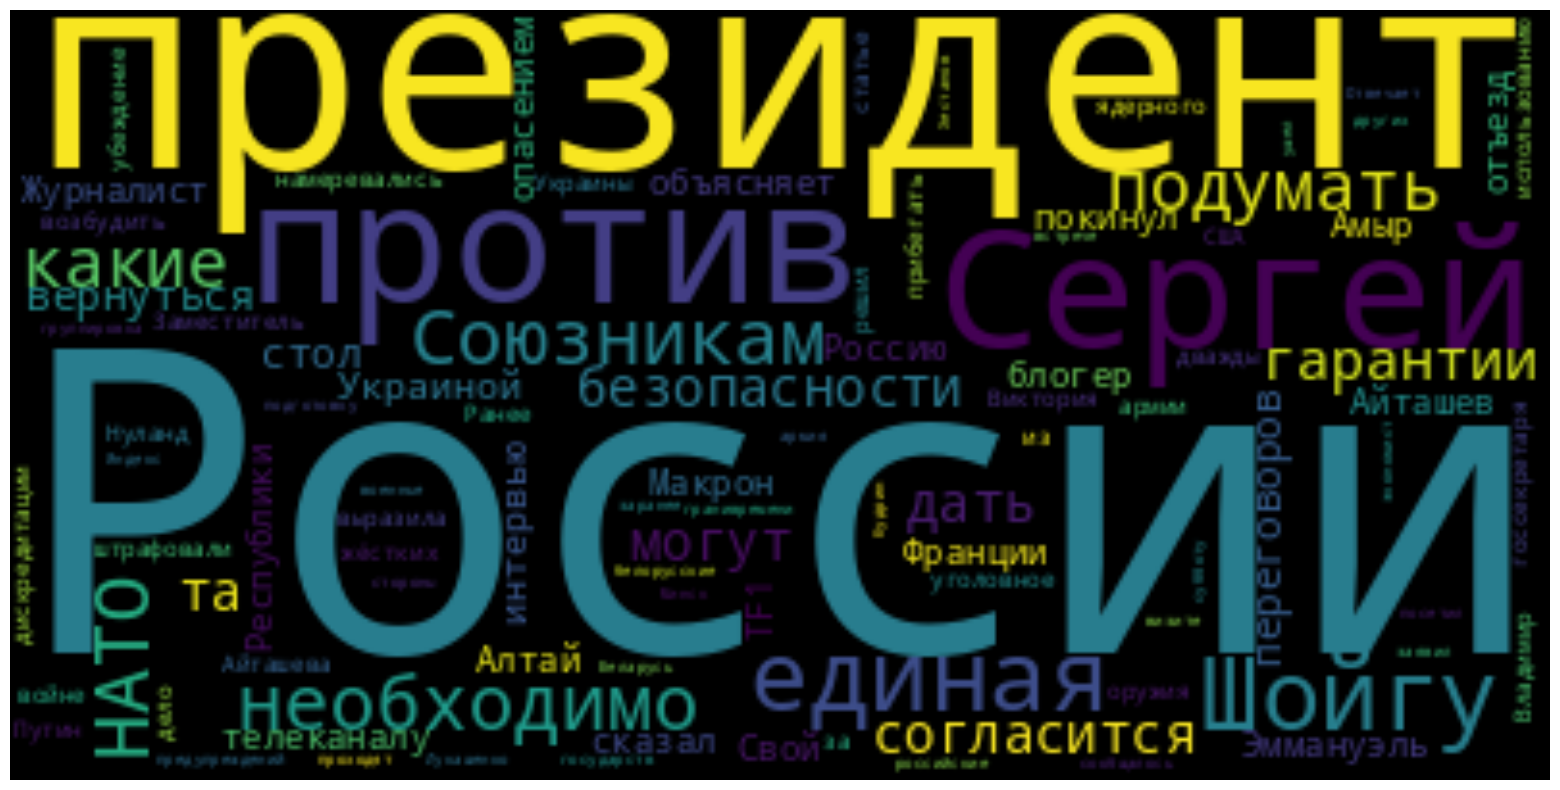

In [77]:
create_wordcloud(tweets_df_tokens, '@SvobodaRadio')

<h2>Performing Entity Recognition and Sentiment Analysis for different
groups of tweets</h2>

In [78]:
print("Loading NLP libraries for English, Ukrainian and Russian languages")

Loading NLP libraries for English, Ukrainian and Russian languages


In [79]:
!python3 -m spacy download en_core_web_sm

nlp_eng = spacy.load('en_core_web_sm')

     |████████████████████████████████| 12.8 MB 4.3 MB/s            
You should consider upgrading via the '/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [80]:
!python3 -m spacy download uk_core_news_sm

nlp_ukr = spacy.load('uk_core_news_sm')

     |████████████████████████████████| 14.9 MB 18.2 MB/s            
You should consider upgrading via the '/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('uk_core_news_sm')


In [81]:
!python3 -m spacy download ru_core_news_sm

nlp_rus = spacy.load('ru_core_news_sm')

     |████████████████████████████████| 15.3 MB 1.0 MB/s            
You should consider upgrading via the '/Users/dennisfenchenko/NYU-Fall-2022/info_vis/confirmation-bias-vis/venv/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [87]:
# Spacy has vocabulary for English, Ukrainian and Russian languages

text = ("Восемь вандалов, которые срезали со стены дома в #Гостомеле женщину "
        "в противогазе авторства #Бэнкси, дали показания полиции #Украина #россия #ВСУ #война #агрессияроссии #вторжениероссии #stoprussia # #войнасукраиной #Войнапутина")

doc = nlp_rus(text)

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text)
    print(entity.text, entity.label_)

(Гостомеле, Бэнкси, Украина, ВСУ)


In [83]:
print("Performing sentiment analysis on tweets")

analyzer = SentimentIntensityAnalyzer()

analyzer.polarity_scores("Вейдер очень умный, красивый и смешной!!!")

Performing sentiment analysis on tweets


{'neg': 0.0, 'neu': 0.281, 'pos': 0.719, 'compound': 0.882}

In [84]:
analyzer.polarity_scores("Новый ракетный удар по мирным жителям Донецка. В сети публикуют момент атаки. Украинские боевики открыли огонь по многоэтажке. Прямое попадание реактивного снаряда. Взрывной волной выбило стекла в соседних зданиях. Два человека погибли https://t.co/xUgOmV4iWN https://t.co/hN8uLeHwzu")

{'neg': 0.234, 'neu': 0.766, 'pos': 0.0, 'compound': -0.9042}

<h2>Performing Entity and Sentiment Analysis</h2>

In [104]:
def augment_entity_to_df(tweets_df, lang='english'):

    new_df = tweets_df.copy(deep=True)

    entities_col = []

    for _, row in tweets_df.iterrows():
        entities = []
        tweet_text = row['Tweet Text']
        tweet_text = clean_tweet(tweet_text)
        if lang == 'english':
            nlp_doc = nlp_eng(tweet_text)
        elif lang == 'russian':
            nlp_doc = nlp_rus(tweet_text)
        elif lang == 'ukrainian':
            nlp_doc = nlp_ukr(text)
        else: raise Exception('Language not supported.')

        # NOTE: enteteties can be filtered based on the entity. e.g. only
        # people
        for entity in nlp_doc.ents:
            entities.append(entity.text)

        entities_col.append(entities)

    new_df['Entities'] = entities_col

    return new_df

# print the list of values


In [105]:
new_df = augment_entity_to_df(tweets_df, lang='russian')
print(new_df)

   Cluster Username  Cluster ID  \
0       @1tvru_news   160881696   
1       @1tvru_news   160881696   
2       @1tvru_news   160881696   
3       @1tvru_news   160881696   
4       @1tvru_news   160881696   
5           @ru_rbc   269770723   
6           @ru_rbc   269770723   
7           @ru_rbc   269770723   
8           @ru_rbc   269770723   
9           @ru_rbc   269770723   
10   @dmitry_gordon  1334400780   
11   @dmitry_gordon  1334400780   
12   @dmitry_gordon  1334400780   
13   @dmitry_gordon  1334400780   
14   @dmitry_gordon  1334400780   
15    @SvobodaRadio    47562921   
16    @SvobodaRadio    47562921   
17    @SvobodaRadio    47562921   
18    @SvobodaRadio    47562921   
19    @SvobodaRadio    47562921   

                                           Tweet Text  \
0   Новые примеры мужества и отваги российских вое...   
1   Дата, навечно вплетенная в летопись нашей воин...   
2   В Подмосковье сегодня чествовали уникальный ко...   
3   Можно покорить любую вершину, ко

In [ ]:
def augment_sent_to_df(tweets_df, lang='english'):
    tweet_tokens_dict = {}
    for _, row in tweets_df.iterrows():
        tweet_text = row['Tweet Text']
        tweet_text = clean_tweet(tweet_text)
        # remove the stopwords
        if lang == 'ukrainian':
            tweet_text = remove_ua_stopwords(tweet_text)
        else:
            tweet_text = remove_stopwords(tweet_text, lang=lang)
        tokenized_tweet = nltk.word_tokenize(tweet_text)
        if row['Cluster Username'] in tweet_tokens_dict.keys():
            tweet_tokens_dict[row['Cluster Username']].extend(tokenized_tweet)
        else:
            tweet_tokens_dict[row['Cluster Username']] = tokenized_tweet

    return tweet_tokens_dict

<h2>Creating Sentiment Visualizations in Plotly</h2>